# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계1 : 데이터 탐색

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

## 1. 개발 환경 설정

* 세부 요구사항
  - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
  - 필요하다고 판단되는 라이브러리를 추가하세요.
  - konlpy, mecab 설치 후 형태소 분석 함수 생성

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget svgling

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

### 1-3. 한글 글꼴 설정

In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.데이터 불러오기

### 2-1. 데이터 로딩

* 다음 데이터를 불러옵니다.
    * 학습 및 검증용 데이터 : train.csv
    * shape를 확인합니다.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/train.csv')
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [ ]:
data.shape

(3706, 2)

### 2-2. 데이터 확인하기
* 문의 유형 분포 확인
* data type, 결측치 확인

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


In [ ]:
data['label'].value_counts()

코드2       1097
웹          732
이론         728
시스템 운영     561
코드1        488
원격         100
Name: label, dtype: int64

<Axes: >

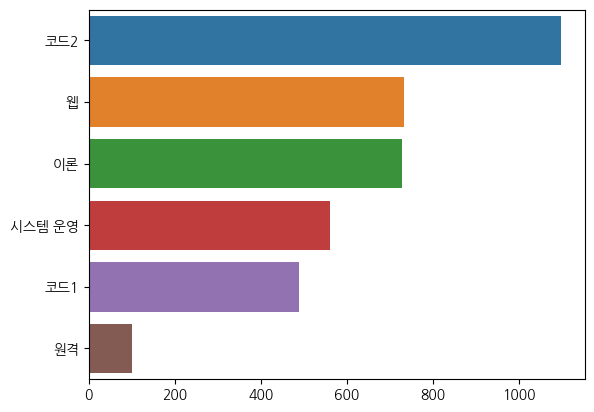

In [ ]:
sns.barplot(x=data['label'].value_counts().values, y=data['label'].value_counts().index)

## 3.데이터 탐색하기


### 3-1. 문의 내용 길이 분포

* 문의 내용의 길이 분포를 확인합니다.
* 최소, 최대 길이의 index 및 문의 내용을 확인합니다.

In [ ]:
data['len'] = data['text'].apply(lambda x : len(x))
data.head()

,text,label,len
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144


In [ ]:
data['len'].max(), data['len'].min()

(6012, 9)

In [ ]:
data.loc[data['len']==6012]

,text,label,len
2561,sns.kdeplot(x = td[var])\nplt.show()\n\n------...,코드2,6012


In [ ]:
data.loc[data['len']==9]

,text,label,len
756,원격 부탁드립니다,원격,9
841,지원부탁드립니다!,원격,9


In [ ]:
data.loc[2651, 'text']

"안녕하세요!  VOC 기반 해지 예측 실습파일 study 2에서\nQ df'에서 컬럼 별 '_'가 50% 이상 차지하는 컬럼들을 찾으세요.  문제에서\n\nfor i in df.columns:\n    if df[i].value_counts(normalize = True)['_'] &gt; 0.5 :\n        print(f'{i}')\n\n로 코드를 작성하였는데 오류 날 이유가 생각하는데 계속 오류가 뜨는데 한번 확인 해 주시면 감사하겠습니다 ㅠㅠ"

### 3-2. 명사 추출하고 품사 태깅하기

* konlpy, MeCab을 활용하여 품사 태깅, 명사 추출하기.
* 2개 이상의 형태소 분석기를 Time analysis 해보기
* Number of Samples / Number of words per sample 구해보기

In [ ]:
# 샘플의 갯수, 샘플 단어의 수?

In [ ]:
# mecab = MeCab()
# print(mecab.nouns('우리나라에는 무릎 치료를 잘하는 정형외과가 없는가!'))
# print(mecab.pos(u'자연주의 쇼핑몰은 어떤 곳인가?'))

In [ ]:
# MeCab을 활용하여 품사 태깅, 명사 추출하기.
mecab = MeCab()
data['nouns'] = data['text'].apply(lambda x : mecab.nouns(x))
data['pos'] = data['text'].apply(lambda x: mecab.pos(x))

In [ ]:
data.head(1)

,text,label,len,nouns,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[(self, SL), (., SY), (convs, SL), (1, SN), (=..."


In [ ]:
# Number of words per sample 구해보기
data['nowos'] = data['pos'].apply(lambda x : len(x))
data.head()

In [ ]:
data.head()

### 3-3. nltk로 텍스트 분석하기
* 3-2.의 명사 추출, 품사 태깅한 데이터를 nltk Text로 변경하기
* 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기
* 각각 Frequency 확인 및 분포 시각화
* 명사 추출한 데이터에서 코드, 웹, 이론, 원격, 시스템 등 관심있는 각 단어에 분석해보기
* 각각 collocation 확인
* 최소 길이 문의 내용에 대해 grammar pasing 해보기(아래 코드 활용)


```python
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"
```

In [ ]:
from nltk import Text
data['nltk_nouns'] = data['nouns'].apply(lambda x : Text(x))
data['nltk_pos'] = data['pos'].apply(lambda x:Text(x))

In [ ]:
data.head(1)

,text,label,len,nouns,pos,nltk_nouns,nltk_pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[(self, SL), (., SY), (convs, SL), (1, SN), (=...","(여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것)","((self, SL), (., SY), (convs, SL), (1, SN), (=..."


In [ ]:
data['morphs'] = data['text'].apply(lambda x : mecab.morphs(x))

In [ ]:
import nltk
cnt = []
for i in data['nltk_pos']:
    for j in i:
       cnt.append(j[0])  # 전체 토큰 추가
print(len(cnt)) #
print(len(set(cnt))) # 중복값 제거
temp = nltk.Text(cnt)
temp.vocab()

297496
11066


FreqDist({'.': 10783, '(': 6452, ',': 6362, '-': 5845, ')': 5668, '_': 5425, '하': 5410, '는': 4475, '이': 4155, '=': 4081, ...})

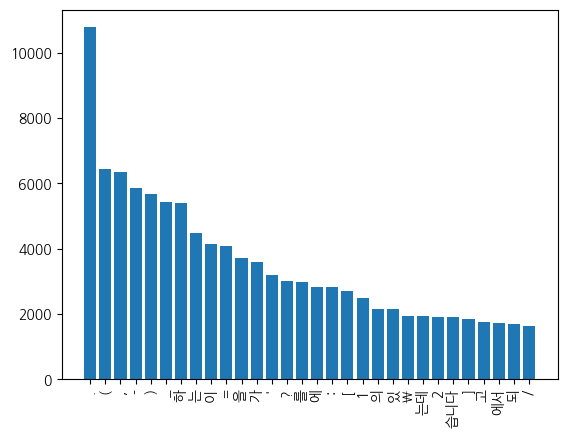

In [ ]:
from collections import Counter
temp = Counter([x for x in cnt]).most_common(30)
x, y = [], []
for i, j in temp:
    x.append(i)
    y.append(j)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

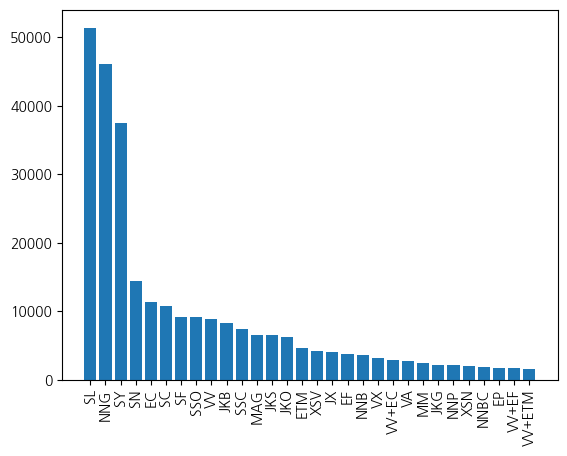

In [ ]:
import nltk
cnt = []
for i in data['nltk_pos']:
    for j in i:
       cnt.append(j[1])
temp = nltk.Text(cnt)

temp = Counter([x for x in cnt]).most_common(30)
x, y = [], []
for i, j in temp:
    x.append(i)
    y.append(j)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

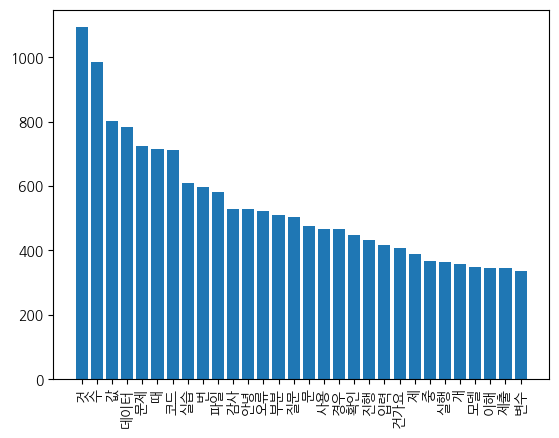

In [ ]:
# 명사별 개수 상위 30개
nouns = [noun for x in data['nouns'] for noun in x]
temp = Counter(nouns).most_common(30)
x, y = [], []
for i, j in temp:
    x.append(i)
    y.append(j)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [ ]:
cnt = []
for i in data['nltk_pos']:
    for j in i:
       cnt.append(j[0])  # 전체 토큰 추가
print(len(cnt)) #
print(len(set(cnt))) # 중복값 제거
temp = nltk.Text(cnt)

297496
11066


In [ ]:
temp.common_contexts(['코드'])

같이_를 에러_가 이렇게_를 실습_를 은_를 으로_를 는_를 의_를 는_가 이_에서 한_에서 위_에서 구_' 게_를 해당_를
라는_를 에서_를 제_는 고_를 해당_에서


In [ ]:
nltk.download('stopwords')
temp.collocations()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


데이터 프레임; recent call; call last; File "",; "", line; import sys;
python manage; 드려도 될까요; -*- coding; init __.; \__ init; 라우팅 테이블; 테스트
케이스; pip install; 데이터 전처리; 하이퍼 파라미터; -*- import; return self; ']].
sum; module named


In [ ]:
temp.collocation_list()

[('데이터', '프레임'),
 ('recent', 'call'),
 ('call', 'last'),
 ('File', '"",'),
 ('"",', 'line'),
 ('import', 'sys'),
 ('python', 'manage'),
 ('드려도', '될까요'),
 ('-*-', 'coding'),
 ('init', '__.'),
 ('\\__', 'init'),
 ('라우팅', '테이블'),
 ('테스트', '케이스'),
 ('pip', 'install'),
 ('데이터', '전처리'),
 ('하이퍼', '파라미터'),
 ('-*-', 'import'),
 ('return', 'self'),
 ("']].", 'sum'),
 ('module', 'named')]

In [ ]:
temp.concordance('코드')

In [ ]:
temp.concordance_list('코드')

In [ ]:
data.head(1)

,text,label,len,nouns,pos,nltk_nouns,nltk_pos,morphs
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[(self, SL), (., SY), (convs, SL), (1, SN), (=...","(여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것)","((self, SL), (., SY), (convs, SL), (1, SN), (=...","[self, ., convs, 1, =, nn, ., ModuleList, (, [..."


In [ ]:
!pip install svgling

(S (NP 원격/NNG 부탁/NNG) (VP 드립니다/VV+EC))
None
원격 부탁
(NP 원격/NNG 부탁/NNG)
None


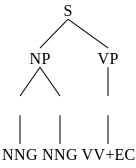

In [ ]:
# 최소길이 문의에 대해 grammar parsing

grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"

sentence = data.loc[np.argmin(data['len']), 'text'] # 가장 짧은 데이터
m = MeCab()
words = m.pos(sentence)

parser = nltk.RegexpParser(grammar)
chunks = parser.parse(words)
print(chunks.pprint())

for subtree in chunks.subtrees():
    if subtree.label() == 'NP':
        print(' '.join((e[0] for e in list(subtree))))
        print(subtree.pprint())

display(chunks)

### 3-4. Wordcloud 만들기
* 명사 추출/형태소 분석 결과를 이용하여 WordCloud 객체를 생성
* 최대 글꼴 크기(max_font_size), 최대 단어 수(max_words), 배경 색상(background_color)
* 상대 크기비율(relative_scaling), 그림 크기(width, height), 폰트 경로(font_path=FONT_PATH) 등 설정
* .generate 메서드를 연결하여 WordCloud에 사용될 텍스트 데이터 생성
* plt.imshow(  ) 를 통해 화면에 보여집니다.

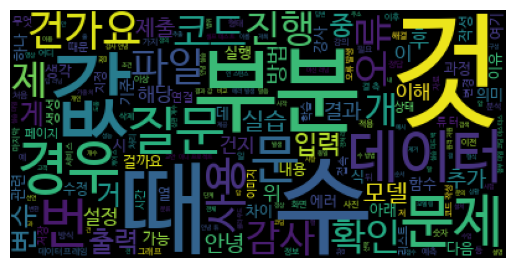

In [ ]:
from wordcloud import WordCloud
nouns = [noun for x in data['nouns'] for noun in x]
# nouns=[]
# for x in data['nouns']:
#     for noun in x:
#         nouns.append(noun)
temp = ' '.join(nouns)
wordcloud = WordCloud(font_path='NanumBarunGothic', max_font_size=100).generate(temp)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
temp = nltk.Text(nouns)
temp.common_contexts(['코드'])

실습_작성 다음_작성 위_실행 아래_실행 에러_발생 구_도착 제_다음 위_결과 문제_작성 방법_작성 소스_실행 위_작성
위_입력 해당_사용 연령_대 아래_작성 번_입력 작성_아래 강사_번 구_이


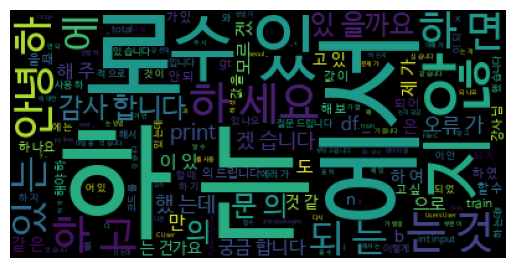

In [ ]:
temp = [morph for x in data['morphs'] for morph in x]
temp = ' '.join(temp)
wordcloud = WordCloud(font_path='NanumBarunGothic', max_font_size=100).generate(temp)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 4. 문의 유형에 따른 분석
### 4-1. *3. 데이터 탐색*에서 실행한 알고리즘을 문의 유형에 따라 실행할 수 있는 함수를 개발합니다.
* 아래 text_analysis 함수를 개발합니다.

In [ ]:
def text_analysis(df, label=None):
    """
    label에 따라서 분석, label이 None인 경우 전체 분석
    데이터 확인, 데이터 길이 시각화
    명사 추출하여 분석, 워드 클라우드 시각화

    Parameters
    ----------
    df : pandas DataFrame object.
    label : Label for analysis, default=None.
    - If label is None, Entire data are analyzed.

    Returns
    -------
    result : None

    """

    pass

### 4-2. 각각의 문의 유형에 대해 실행합니다.

In [ ]:
for label in sorted(data.label.unique()):
    text_analysis(data,label)

# 단계2 : 데이터 전처리
> * Tokenization(Konlpy...)
> * Vectorization(N-grams, Sequence)
> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-3)

## 5. 데이터 준비
### 5-1. label 아래 형식으로 처리
```python
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
```

In [ ]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

In [ ]:
data['label'].value_counts()

코드2       1097
웹          732
이론         728
시스템 운영     561
코드1        488
원격         100
Name: label, dtype: int64

In [ ]:
data['label'] = data['label'].apply(lambda x : label_dict[x])
data['label'].value_counts()

0    1585
1     732
2     728
3     561
4     100
Name: label, dtype: int64

In [ ]:
data.head(1)

,text,label,len,nouns,pos,nltk_nouns,nltk_pos,morphs
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[(self, SL), (., SY), (convs, SL), (1, SN), (=...","(여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것)","((self, SL), (., SY), (convs, SL), (1, SN), (=...","[self, ., convs, 1, =, nn, ., ModuleList, (, [..."


### 5-2. Train Validation split

In [ ]:
data_org = data.copy()

In [ ]:
data = data_org.copy()

In [ ]:
x=data[['text']]
y=data['label']

In [ ]:
x.head()

,text
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x,y,test_size=0.2, stratify=y)

## 6. 데이터 처리

### 6-1. 특수문자 제거(Optional)
- [정규표현식 이용](https://docs.python.org/3/howto/regex.html)

In [ ]:
import re

def remove_special_characters(input_string):
    # 한글, 알파벳, 숫자를 제외한 모든 특수문자를 공백으로 대체
    output_string = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", ' ', input_string)
    return output_string

In [ ]:
x_tr['text'] = x_tr['text'].apply(lambda x : remove_special_characters(x))
x_val['text'] = x_val['text'].apply(lambda x : remove_special_characters(x))

In [ ]:
x_tr.shape

(2964, 1)

In [ ]:
x_tr

,text
2670,실습1 \n협력사에서 일한 경험을 바탕으로 하여 고객사 입장에서 바라봤을때 가정하...
795,안녕하세요 몇가지 질문이 있어서 올립니다 \n\n1 train test se...
1144,Q2 Answer template\n\nN int input N 입력 ...
953,2 3에서 WindowSearch exe 를 치고나면\nThe system can...
1946,여기서 용병을 뽑는 개수가 정해져 있는 건가요 예제1에서 입력은 4명인데 최대...
...,...
738,모델을 저장한다는 안내가 2번 나왔는데 덮어서 저장되는 건가요 \nsave bes...
215,data data iloc 2 \n해당 코드에서 iloc가 정확히 무엇인지...
509,1 feature간에 독립인게 선형회귀 로지스틱 회귀라고 들었습니다 \n그러면 ...
1784,Get 방식으로 데이터를 불러올 때 url에서 물음표를 기준으로 뒤에 쿼리가 작성...


### 6-2. N-grams (sklearn)
> * [scikit-learn working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#)
> * [scikit-learn text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
> * [한글 자료](https://datascienceschool.net/03%20machine%20learning/03.01.03%20Scikit-Learn%EC%9D%98%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EB%8A%A5.html)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vect = CountVectorizer(ngram_range=(1, 2),token_pattern=r"(?u)\b\w+\b")
vect.fit(x_tr['text'])
x_tr_ng = vect.transform(x_tr['text'])
x_tr_ng

<2964x100027 sparse matrix of type '<class 'numpy.int64'>'
	with 185537 stored elements in Compressed Sparse Row format>

In [ ]:
x_val_ng = vect.transform(x_val['text'])
x_val_ng

<742x100027 sparse matrix of type '<class 'numpy.int64'>'
	with 24859 stored elements in Compressed Sparse Row format>

In [ ]:
x_tr_ng = x_tr_ng.toarray()
x_val_ng = x_val_ng.toarray()

In [ ]:
x_tr_ng.shape, x_val_ng.shape

((2964, 100027), (742, 100027))

In [ ]:
nouns=[]
mecab = MeCab()
for i in x_tr:
    noun = mecab.morphs(i)
    nouns.append(noun)

In [ ]:
nouns[:3]

In [ ]:
def mecab_tokenizer(text):
    return mecab.morphs(text)

### n_gram 특수문자 전처리 & 모델링

In [ ]:
import re
import string
#removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, -,∼,=,ㆍ<,>, .,?, !,【,】, …, ◆,%"
removal_list =  "‘’◇‘”’'·\“·△●■()\">>`/-∼=ㆍ<>.?!【】…◆%"
removal_list += string.punctuation
def cleansing_special(sentence: str = None) -> str:
    """
    특수문자를 전처리를 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    #sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)

    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    return sentence

In [ ]:
data.head(1)

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0


In [ ]:
data['text'] = data['text'].apply(lambda x : cleansing_special(x))

In [ ]:
data.head(1)

,text,label
0,self convs1 nn ModuleList nn Conv2d 1 Co K 100...,0


In [ ]:
data.to_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/pre_data.csv', index=False)

In [ ]:
X_tr,X_val,Y_tr,Y_val = train_test_split(data.text,data.label, test_size=0.2)

In [ ]:
def mecab_tokenizer(string):
    return list("/".join(res) for res in mecab.pos(str(string)))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=mecab_tokenizer)
x_tr_tfidfv = tfidf_vectorizer.fit_transform(X_tr)
x_val_tfidfv = tfidf_vectorizer.transform(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
x_tr_tfidfv = x_tr_tfidfv.toarray()
x_val_tfidfv = x_val_tfidfv.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *

classifier = GaussianNB()
classifier.fit(x_tr_tfidfv, Y_tr)

preds = classifier.predict(x_val_tfidfv)

# gaussia NB / data preprocess: seq
print(accuracy_score(Y_val,preds))

0.7318059299191375


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_tr_tfidfv, Y_tr)

preds = classifier.predict(x_val_tfidfv)

# gaussia NB / data preprocess: seq
print(accuracy_score(Y_val,preds))

0.8221024258760108


In [ ]:
len(tfidf_vectorizer.vocabulary_)

9550

In [ ]:
np.save(file_path("x_tr_tfidfv"), arr = x_tr_tfidfv)
np.save(file_path("x_val_tfidfv"), arr = x_val_tfidfv)

NameError: ignored

### 6-3. Sequence (keras, whatever)
> * [keras text classification](https://keras.io/examples/nlp/text_classification_from_scratch/)
> * [tensorflow text classification](https://www.tensorflow.org/tutorials/keras/text_classification)
* tokenizer.fit_on_texts() : 주어진 텍스트 데이터에 대해 단어 사전 생성
* 문장 길이 분포 살펴보기
* 문장 길이를 구해서 기초통계량, histogram, boxplot을 그려보고 적절한 개수를 결정합니다.
* tokenizer.texts_to_sequences() : 주어진 텍스트 데이터를 정수 시퀀스로 변환

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 10000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [ ]:
seq_x_tr, seq_x_val, word_index = sequence_vectorize(x_train_noun, x_val_noun)

In [ ]:
print(word_index)

{'수': 1, '값': 2, '데이터': 3, '문제': 4, '코드': 5, '실습': 6, '번': 7, '파일': 8, '오류': 9, '감사': 10, '안녕': 11, '부분': 12, '질문': 13, '사용': 14, '경우': 15, '문': 16, '확인': 17, '진행': 18, '입력': 19, '건가요': 20, '중': 21, '실행': 22, '개': 23, '제출': 24, '이해': 25, '출력': 26, '모델': 27, '변수': 28, '방법': 29, '결과': 30, '에러': 31, '후': 32, '게': 33, '작성': 34, '거': 35, '해당': 36, '시': 37, '해결': 38, '발생': 39, '추가': 40, '첨부': 41, '강사': 42, '내용': 43, '위': 44, '이유': 45, '걸까요': 46, '부탁': 47, '생각': 48, '함수': 49, '건지': 50, '설정': 51, '설명': 52, '가능': 53, '관련': 54, '학습': 55, '열': 56, '데': 57, '아래': 58, '의미': 59, '사진': 60, '답변': 61, '강의': 62, '분석': 63, '과정': 64, '코딩': 65, '예측': 66, '차이': 67, '이미지': 68, '저장': 69, '변경': 70, '생성': 71, '테스트': 72, '제거': 73, '이용': 74, '기준': 75, '케이스': 76, '점': 77, '접속': 78, '수정': 79, '연결': 80, '요청': 81, '터': 82, '식': 83, '전처리': 84, '차': 85, '수업': 86, '분': 87, '리스트': 88, '지정': 89, '튜': 90, '처리': 91, '프레임': 92, '페이지': 93, '상태': 94, '자료': 95, '과제': 96, '때문': 97, '상관': 98, '프로젝트': 99, '원격': 100, '스턴스': 101, '명

In [ ]:
len_seq_x_tr = [len(x) for x in seq_x_tr]
max(len_seq_x_tr), min(len_seq_x_tr)

(500, 500)

In [ ]:
sns.boxplot(x=len_seq_x_tr)
plt.show()
sns.histplot(x=len_seq_x_tr)
plt.show()
display(pd.Series(len_seq_x_tr).describe())

In [ ]:
len_seq_x_val = [len(x) for x in seq_x_val]
max(len_seq_x_val), min(len_seq_x_val)

(601, 0)

In [ ]:
sns.boxplot(x=len_seq_x_val)
plt.show()
sns.histplot(x=len_seq_x_val)
plt.show()
display(pd.Series(len_seq_x_val).describe())

In [ ]:
word_index

In [ ]:
seq_x_tr_pd = sequence.pad_sequences(seq_x_tr, maxlen=20)
seq_x_val_pd = sequence.pad_sequences(seq_x_val, maxlen=20)

### 강사님 sequence 코드

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from keras.preprocessing import sequence
from keras.preprocessing import text
TOP_K = 5000
MAX_SEQUENCE_LENGTH = 500
X_mor_tr_str = X_tr.apply(lambda x:' '.join(mecab_tokenizer(x)))
X_mor_val_str = X_val.apply(lambda x:' '.join(mecab_tokenizer(x)))

X_mor_tr = X_tr.apply(lambda x:mecab_tokenizer(x))
X_mor_val = X_val.apply(lambda x:mecab_tokenizer(x))

In [ ]:
tokenizer = text.Tokenizer(num_words=TOP_K, char_level=False)
tokenizer.fit_on_texts(X_mor_tr)
X_mor_tr_seq = tokenizer.texts_to_sequences(X_mor_tr)
X_mor_val_seq = tokenizer.texts_to_sequences(X_mor_val)


max_length = len(max(X_mor_tr_seq, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

print(max_length)
X_mor_tr_seq = sequence.pad_sequences(X_mor_tr_seq, maxlen=max_length)
X_mor_val_seq = sequence.pad_sequences(X_mor_val_seq, maxlen=max_length)


500


In [ ]:
from gensim.models import Word2Vec, FastText,KeyedVectors
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
SIZE = 128 # embedding_size
WINDOW = 3
MIN_COUNT = 1
w2v_model = Word2Vec(sentences=X_mor_tr,
                vector_size=SIZE,
                window=WINDOW,
                max_vocab_size=None,
                min_count=MIN_COUNT,
                workers=4,
                epochs=10,
                negative=5,
                sg=0)

In [ ]:
def get_sent_embeddings(model, embedding_size, tokenized_words,index2word_set):

    # 단어 임베딩 및 n_words의 크기가 0인 feature_vec 배열을 0으로 초기화합니다.
    # 또한 model.wv.index2word를 사용하여 Word2Vec 모델의 어휘에 단어 세트를 생성합니다.
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    n_words = 0


    # 토큰화된 문장의 각 단어를 반복하고 Word2Vec 모델의 어휘에 존재하는지 확인합니다.
    # 그렇다면 n_words가 증가하고 단어의 임베딩이 feature_vec에 추가됩니다.
    for word in tokenized_words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Word2Vec 모델의 어휘에 있는 입력 문장에 단어가 있는지 확인합니다.
    # 있다면 feature_vec를 n_words로 나누어 입력 문장의 평균 임베딩을 구합니다.
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec
def get_dataset(sentences, model, num_features):

    # 각 문장에 대한 임베딩을 보유할 dataset이라는 빈 목록을 초기화합니다.
    dataset = list()
    index2word_set = set(model.wv.index_to_key)
    # 문장의 각 문장을 반복하고 앞에서 설명한 get_sent_embeddings() 함수를 사용하여 문장에 대한 평균 임베딩을 생성합니다.
    # 결과 문장 임베딩이 데이터 세트 목록에 추가됩니다.
    for sent in sentences:
        dataset.append(get_sent_embeddings(model, num_features, sent,index2word_set))

    # 루프에서 생성된 문장 임베딩을 sent_embedding_vectors라는 2차원 배열에 쌓습니다.
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

In [ ]:
pre_trained = Word2Vec.load('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/word2vec')

In [ ]:
for index, word in enumerate(w2v_model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(w2v_model.wv.index_to_key)} is {word}")
for index, word in enumerate(pre_trained.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(pre_trained.wv.index_to_key)} is {word}")

word #0/9909 is 하/XSV
word #1/9909 is 가/JKS
word #2/9909 is 을/JKO
word #3/9909 is 는/ETM
word #4/9909 is 이/JKS
word #5/9909 is 를/JKO
word #6/9909 is 에/JKB
word #7/9909 is 1/SN
word #8/9909 is 의/JKG
word #9/9909 is 습니다/EF
word #0/358043 is 1
word #1/358043 is .
word #2/358043 is 0
word #3/358043 is 2
word #4/358043 is 의
word #5/358043 is ,
word #6/358043 is 이
word #7/358043 is 는
word #8/358043 is 다
word #9/358043 is )


In [ ]:
print(w2v_model.wv.similar_by_word("문제/NNG"))
print(pre_trained.wv.similar_by_word("문제"))

[('예시/NNG', 0.8493552803993225), ('풀이/NNG', 0.8315462470054626), ('어디/NP', 0.8178514838218689), ('푼/VV+ETM', 0.7991718053817749), ('제/NP', 0.7930664420127869), ('제/NP+JKG', 0.7833283543586731), ('그리고/MAJ', 0.7827557325363159), ('해당/NNG', 0.7825302481651306), ('상태/NNG', 0.7798211574554443), ('범위/NNG', 0.7793259024620056)]
[('해결', 0.7485990524291992), ('문제점', 0.7430223822593689), ('이유', 0.7247400879859924), ('휘청이', 0.7205255031585693), ('논의', 0.7197678089141846), ('시시비비', 0.711897075176239), ('상황', 0.7107261419296265), ('불거질', 0.7100738286972046), ('인력난', 0.7081537842750549), ('더래도', 0.7055107355117798)]


In [ ]:
X_pr_tr = get_dataset(X_tr.apply(lambda x: mecab.morphs(x)), pre_trained, 100)
X_pr_val = get_dataset(X_val.apply(lambda x: mecab.morphs(x)), pre_trained, 100)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_pr_tr, Y_tr)

preds = classifier.predict(X_pr_val)

# gaussia NB / data preprocess: seq
print(accuracy_score(Y_val,preds))

0.7055016181229773


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 한국어 불용어 처리

In [ ]:
filename = '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/stopword.txt'
with open(filename) as f:
    stop = f.read()
stop_words = set(stop.split('\n'))
print(stop_words)

{'조차', '전부', '여보시오', '붕붕', '어찌하여', '댕그', '설마', '위하여', '바꾸어서 말하면', '관련이 있다', '각', '다만', '한 이유는', '만큼\t어찌됏든', '하지만', '통하여', '논하지 않다', '의해서', '잠깐', '오히려', '하지마라', '입장에서', '만 못하다\t하기보다는', '향하다', '참나', '하나', '요만한 것', '이때', '공동으로', '어떻해', '된이상', '와 같은 사람들', '비걱거리다', '끼익', '흥', '도착하다', '얼마만큼', '그렇게 함으로써', '그렇지 않다면', '비로소', '형식으로 쓰여', '이렇다', '예를 들자면', '전후', '그중에서', '아니라면', '하려고하다', '그치지 않다', '이외에도', '하마터면', '자기', '결과에 이르다', '허허', '시작하여', '또', '겨우', '그러므로', '의지하여', '네', '그에 따르는', '허', '연이서', '대해 말하자면', '이지만', '하면서', '그런 까닭에', '생각한대로', '그러면', '이 밖에', '어떤것', '아래윗', '답다', '그렇지', '을', '하다', '저쪽', '하여금', '어느', '이천칠', '그리고', '제각기', '훨씬', '둥둥', '다른', '불구하고', '모두', '있다', '어느쪽', '영차', '쾅쾅', '점에서 보아', '아이쿠', '일것이다', '왜', '어떤것들', '얼마 안 되는 것', '할수있어', '까악', '놀라다', '과연', '만 못하다', '이천육', '한적이있다', '에 가서', '시각', '진짜로', '그', '줄은 몰랏다', '든간에', '설사', '본대로', '이와 같은', '저기', '이', '팍', '예컨대', '엉엉', '오로지', '하게하다', '즉', '과', '조금', '까지', '고로', '딱', '다수', '향해서', '쿵', '소인', '아야', '마저도', '칠', '매번', '하겠는가', '육', '만이 아니다', '관

In [ ]:
x_train_noun = []
mecab = MeCab()
for i in x_tr:
    temp = mecab.nouns(i)
    result = [word for word in temp if word not in stop_words]
    x_train_noun.append(result)

x_val_noun = []
mecab = MeCab()
for i in x_val:
    temp = mecab.nouns(i)
    result = [word for word in temp if word not in stop_words]
    x_val_noun.append(result)

In [ ]:
x_train_noun = [' '.join(x) for x in x_train_noun]
x_val_noun = [' '.join(x) for x in x_val_noun]

In [ ]:
x_train_morph = []
mecab = MeCab()
for i in x_tr:
    temp = mecab.morphs(i)
    result = [word for word in temp if word not in stop_words]
    x_train_morph.append(result)

x_val_morph = []
mecab = MeCab()
for i in x_val:
    temp = mecab.morphs(i)
    result = [word for word in temp if word not in stop_words]
    x_val_morph.append(result)

In [ ]:
x_train_morph = [' '.join(x) for x in x_train_morph]
x_val_morph = [' '.join(x) for x in x_val_morph]

In [ ]:
def mecab_tokenizer(text):
    return mecab.morphs(text)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=mecab_tokenizer)
x_tr_no_tfidfv = tfidf_vectorizer.fit_transform(x_train_morph)
x_val_no_tfidfv = tfidf_vectorizer.transform(x_val_morph)
x_tr_no_tfidfv = x_tr_no_tfidfv.toarray()
x_val_no_tfidfv = x_val_no_tfidfv.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# 데이터 전처리 함수

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
import re
# 데이터 전처리 함수
def data_preprocessing(data):
    # label값 변환
    label_dict = {
        '코드1': 0,
        '코드2': 0,
        '웹': 1,
        '이론': 2,
        '시스템 운영': 3,
        '원격': 4
    }
    data['label'] = data['label'].apply(lambda x : label_dict[x])
    x=data['text']
    y=data['label']
    # train, valid로 나누기
    x_tr, x_val, y_tr, y_val = train_test_split(x,y,test_size=0.2, stratify=y)
    # 정규식으로 특수문자 공백으로 대체
    x_tr = x_tr.apply(lambda x : re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", ' ', x))
    x_val = x_val.apply(lambda x : re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", ' ', x))

    return x_tr, x_val, y_tr, y_val

def n_gram(x_tr, x_val):
    # N-grams
    vect = CountVectorizer(ngram_range=(1, 2),token_pattern=r"(?u)\b\w+\b")
    vect.fit(x_tr)
    x_tr_ng = vect.transform(x_tr).toarray()
    x_val_ng = vect.transform(x_val).toarray()

    return x_tr_ng, x_val_ng

def seq_len(x_tr, x_val, T0P_K=10000):
    # train의 단어 사전 생성
    tokenizer = text.Tokenizer(num_words=T0P_K)
    tokenizer.fit_on_texts(x_tr)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(x_tr)
    x_val = tokenizer.texts_to_sequences(x_val)

    # train sequence 문장 길이의 boxplot, histplot, describe
    len_seq_x_tr = [len(x) for x in x_train]
    sns.boxplot(x=len_seq_x_tr)
    plt.show()
    sns.histplot(x=len_seq_x_tr)
    plt.show()
    display(pd.Series(len_seq_x_tr).describe())

    # valid sequence 문장 길이의 boxplot, histplot, describe
    len_seq_x_val = [len(x) for x in x_val]
    sns.boxplot(x=len_seq_x_val)
    plt.show()
    sns.histplot(x=len_seq_x_val)
    plt.show()
    display(pd.Series(len_seq_x_val).describe())

    return x_train, x_val, tokenizer.word_index

def sequence_pad(seq_x_tr, seq_x_val, max_len = 20):
    seq_x_tr_pd = sequence.pad_sequences(seq_x_tr, maxlen=max_len)
    seq_x_val_pd = sequence.pad_sequences(seq_x_val, maxlen=max_len)
    return seq_x_tr_pd, seq_x_val_pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/train.csv')

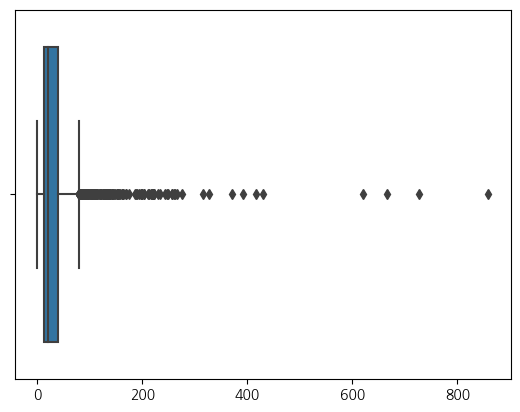

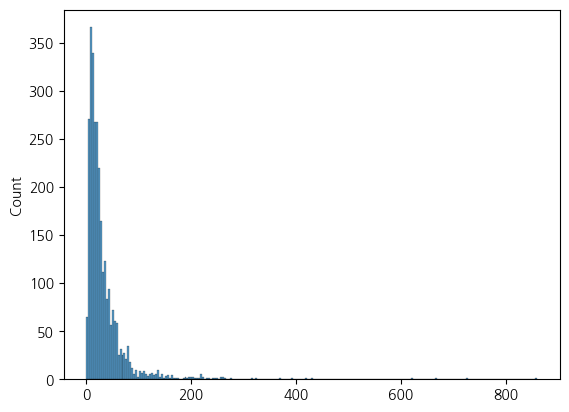

count    2964.000000
mean       32.930162
std        44.420560
min         0.000000
25%        12.000000
50%        21.000000
75%        39.000000
max       859.000000
dtype: float64

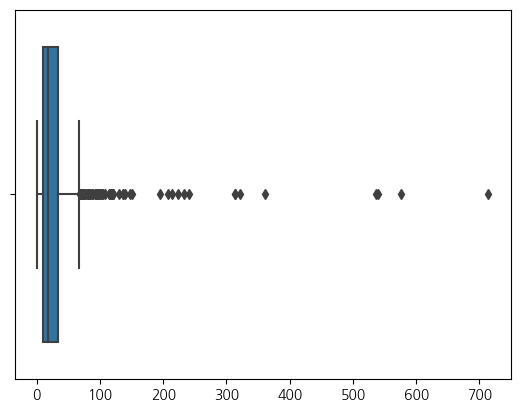

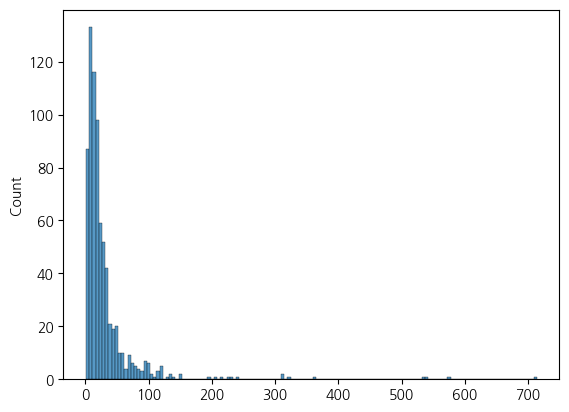

count    742.000000
mean      31.983827
std       55.899005
min        1.000000
25%       10.000000
50%       18.000000
75%       33.000000
max      714.000000
dtype: float64

In [ ]:
x_tr, x_val, y_tr, y_val = data_preprocessing(data)
x_tr_ng, x_val_ng = n_gram(x_tr, x_val)
seq_x_tr, seq_x_val, word_index = seq_len(x_tr, x_val)
seq_x_tr_pd, seq_x_val_pd = sequence_pad(seq_x_tr, seq_x_val)

# 모델링

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *

classifier = GaussianNB()
classifier.fit(seq_x_tr, y_tr)

preds = classifier.predict(seq_x_val)

# gaussia NB / data preprocess: seq
print(accuracy_score(y_val,preds))

0.057951482479784364


In [ ]:
classifier = GaussianNB()
classifier.fit(x_tr_tfidfv, y_tr)
preds = classifier.predict(x_val_tfidfv)
# gaussia NB / data preprocess: seq
print(accuracy_score(y_val,preds))

0.7277628032345014


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(seq_x_tr, y_tr)

preds = classifier.predict(seq_x_val)

# gaussia NB / data preprocess: seq
print(accuracy_score(y_val,preds))

0.40161725067385445


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_tr_no_tfidfv, y_tr)

preds = classifier.predict(x_val_no_tfidfv)

# gaussia NB / data preprocess: seq
print(accuracy_score(y_val,preds))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_tr_tfidfv, y_tr)

preds = classifier.predict(x_val_tfidfv)

# gaussia NB / data preprocess: seq
print(accuracy_score(y_val,preds))

0.7318059299191375


In [ ]:
x_tr_ng.shape

(2964, 99272)

### 6-4. Word2Vec (gensim, optional)
> * [gensim-word2vec-tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)
> * [tensorflow-word2vec-tutorial](https://www.tensorflow.org/tutorials/text/word2vec?hl=ko)

In [ ]:
# 아래 함수는 제공합니다.
def get_sent_embeddings(model, embedding_size, tokenized_words):

    # 단어 임베딩 및 n_words의 크기가 0인 feature_vec 배열을 0으로 초기화합니다.
    # 또한 model.wv.index2word를 사용하여 Word2Vec 모델의 어휘에 단어 세트를 생성합니다.
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)

    # 토큰화된 문장의 각 단어를 반복하고 Word2Vec 모델의 어휘에 존재하는지 확인합니다.
    # 그렇다면 n_words가 증가하고 단어의 임베딩이 feature_vec에 추가됩니다.
    for word in tokenized_words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Word2Vec 모델의 어휘에 있는 입력 문장에 단어가 있는지 확인합니다.
    # 있다면 feature_vec를 n_words로 나누어 입력 문장의 평균 임베딩을 구합니다.
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec
def get_dataset(sentences, model, num_features):

    # 각 문장에 대한 임베딩을 보유할 dataset이라는 빈 목록을 초기화합니다.
    dataset = list()

    # 문장의 각 문장을 반복하고 앞에서 설명한 get_sent_embeddings() 함수를 사용하여 문장에 대한 평균 임베딩을 생성합니다.
    # 결과 문장 임베딩이 데이터 세트 목록에 추가됩니다.
    for sent in sentences:
        dataset.append(get_sent_embeddings(model, num_features, sent))

    # 루프에서 생성된 문장 임베딩을 sent_embedding_vectors라는 2차원 배열에 쌓습니다.
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

### 6-5. 데이터 저장하기
* N-gram, Sequence로 처리한 데이터 저장
* sparse data에 대해서는 scipy.sparse.save_npz 활용

In [ ]:
import numpy as np
import scipy.sparse

In [ ]:
PATH = '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료'

In [ ]:
def file_path(path):
    return PATH +"/"+path

In [ ]:
np.save(file_path("X_mor_sequence_train"), arr = X_mor_tr_seq)
np.save(file_path("X_mor_sequence_val"), arr = X_mor_val_seq)

In [ ]:
np.save(file_path("x_tr_tfidfv"), arr = x_tr_tfidfv)
np.save(file_path("x_val_tfidfv"), arr = x_val_tfidfv)

In [ ]:
np.save(file_path("y_train"), arr = Y_tr)
np.save(file_path("y_val"), arr = Y_val)

# 맞춤법 검사기